In [5]:
import pickle as pkl
import numpy as np
import yaml
import naplib as nl
from sklearnex import patch_sklearn
import matplotlib.pyplot as plt
from naplib.visualization.plots import strf_plot

patch_sklearn()

from sklearn.linear_model import Ridge
import thesis

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [6]:
with open("prep_response.npy", "rb") as f:
    small_response = np.load(f)
with open("prep_spec.npy", "rb") as f:
    spec = np.load(f)

with open("code_params.yaml", "r") as file:
    code_params = yaml.load(file, yaml.Loader)

In [ ]:
# apply STRF
from sklearn.preprocessing import StandardScaler

print(small_response.shape)

# normalize and center X and y
#print(spec.shape)
#spec_scaled = StandardScaler().fit_transform(spec)
#resp_scaled = StandardScaler().fit_transform(small_response)
print(spec_scaled.shape)


tmin = 0
tmax = code_params["max_lag"]

strf_model = nl.encoding.TRF(
    tmin, tmax, code_params["sr_response"], estimator=Ridge(10), show_progress=True
)
filename = f'strf_coefs_{code_params["max_lag"]}_{code_params["nr_trials"]}_trials.pkl'

try:
    with open(filename, "rb") as file:
        coef_ridge = pkl.load(file)
except FileNotFoundError:
    print(spec.shape)
    print(small_response.shape)

    strf_model.fit(X=spec, y=small_response)
    coef_ridge = strf_model.coef_
    with open(filename, "wb") as file:
        pkl.dump(coef_ridge, file)

(90, 420, 25840)
(90, 420, 129)


ValueError: Found array with dim 3. StandardScaler expected <= 2.

(25840, 129, 6)
(25840, 129, 6)


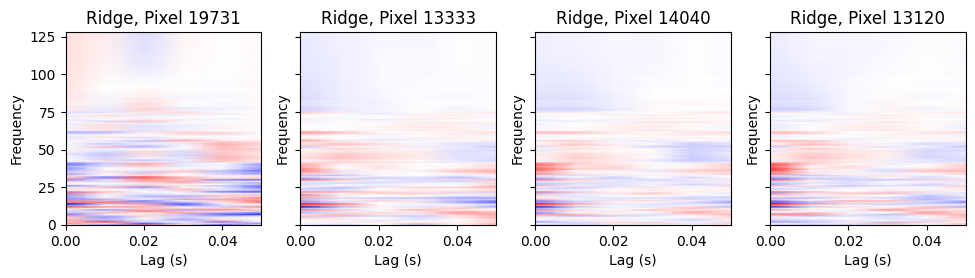

In [ ]:
from sklearn.preprocessing import normalize

nr_plots = 4
count = 0
num_channels = coef_ridge.shape[0]
print(coef_ridge.shape)
pixels = np.random.randint(0, num_channels, nr_plots)
avg_strf_list = []
orig_shape = coef_ridge.shape
coef_ridge = normalize(np.reshape(coef_ridge, (num_channels, -1)), axis=1).reshape(
    orig_shape
)
coefs_mean = np.mean(coef_ridge)
print(coef_ridge.shape)

fig, axes = plt.subplots(1, nr_plots, figsize=(6, 2.5), sharey=True)
pixel_indices = []
for pixel in pixels:
    pixel_coefs = coef_ridge[pixel]
    strf_plot(pixel_coefs, tmin=tmin, tmax=tmax, ax=axes[count])
    pixel_indices.append(pixel)
    axes[count].set_title(f"Ridge, Pixel {pixel}")
    count += 1
    if count == nr_plots:
        break
plt.subplots_adjust(left=1, right=2.5)
plt.show()

(25840, 129, 6)


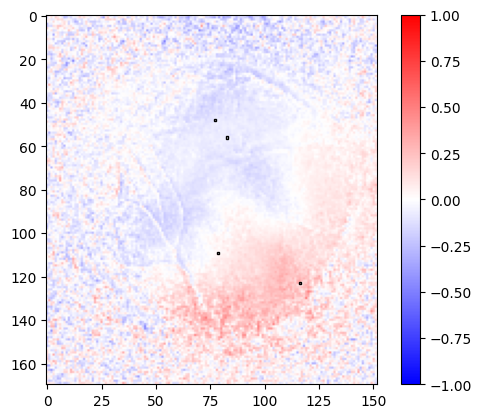

In [ ]:
def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x - 0.5, y - 0.5), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


avg_strf_list = np.array([np.mean(coef) for coef in coef_ridge])
print(coef_ridge.shape)
avg_response = np.mean(small_response, axis=(0, 1))
avg_strf_list = avg_strf_list.reshape(
    (code_params["prep_resp_dims"][0], code_params["prep_resp_dims"][1])
)
avg_strf_list = (avg_strf_list - np.mean(avg_strf_list)) / (
    np.max(avg_strf_list) - np.min(avg_strf_list)
)
plt.imshow(avg_strf_list, cmap="bwr", vmin=-1, vmax=1)
for i in pixel_indices:
    highlight_cell(i / height, i % width)
plt.colorbar()

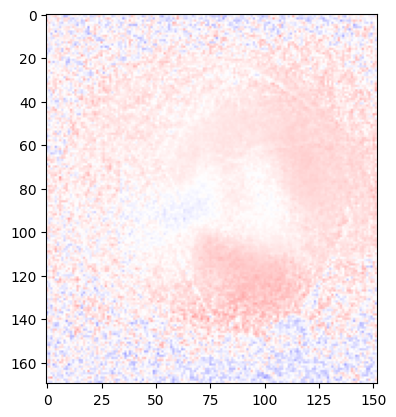

In [ ]:
from IPython.display import Video
from matplotlib import animation, cm

temporal_avg_strf_list = np.mean(coef_ridge, axis=1)
temporal_avg_strf_list = (temporal_avg_strf_list - np.mean(temporal_avg_strf_list)) / (
    np.max(temporal_avg_strf_list) - np.min(temporal_avg_strf_list)
)
temporal_avg_strf_list = np.transpose(temporal_avg_strf_list)
temporal_avg_strf_list = temporal_avg_strf_list.reshape(
    -1, code_params["prep_resp_dims"][0], code_params["prep_resp_dims"][1]
)

frames = []
fig = plt.figure()
for frame in temporal_avg_strf_list:
    frames.append([plt.imshow(frame, cmap="bwr", vmin=-1, vmax=1, animated=True)])
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
ani.save(f"temp_strf_{code_params['max_lag']}_{code_params['nr_trials']}_trials.mkv")
plt.show()